<a href="https://colab.research.google.com/github/alifahaq/project-celerates/blob/main/rekomendasi%20produk%20di%20Tokopedia.ipynb" target="_parent"><img src="https://colab.research.google.com/assets/colab-badge.svg" alt="Open In Colab"/></a>

In [ ]:
import pandas as pd

df = pd.read_csv("review_data.csv")
print(df.head())
print(df.columns)
print(df.info())

MODE = "full"   # ganti ke "full" cuma sekali nanti aja kalau sudah selesai streamlit, kode ini jangan dihapus.

if MODE == "dev":
    df = df.sample(n=1000, random_state=42)
else:
    df = df.sample(n=10000, random_state=42)

   review_id date_published  rating_value  best_rating  \
0  351645103     2025-07-10           3.0          5.0   
1  349938731     2025-06-17           5.0          5.0   
2  348900301     2025-06-08           5.0          5.0   
3  347053222     2025-05-24           4.0          5.0   
4  346825636     2025-05-21           3.0          5.0   

                            title  \
0  This lip balm is a miss for me   
1                             NaN   
2                             NaN   
3               amazing… at times   
4                       It’s okay   

                                                text  \
0  It’s much thinner than I thought it would be a...   
1  Consistency is a great mix between a balm and ...   
2  As someone who never writes reviews, I HAD TO ...   
3  i’m lucky enough to have tried multiple tubes ...   
4  It’s not good or bad, just in the middle. It d...   

                                       item_reviewed  label  
0  Plumping & Softening Sweet

In [ ]:
df = df.drop_duplicates()
df = df.dropna()
print(df.info())

<class 'pandas.core.frame.DataFrame'>
Index: 7929 entries, 13637 to 12782
Data columns (total 8 columns):
 #   Column          Non-Null Count  Dtype  
---  ------          --------------  -----  
 0   review_id       7929 non-null   int64  
 1   date_published  7929 non-null   object 
 2   rating_value    7929 non-null   float64
 3   best_rating     7929 non-null   float64
 4   title           7929 non-null   object 
 5   text            7929 non-null   object 
 6   item_reviewed   7929 non-null   object 
 7   label           7929 non-null   object 
dtypes: float64(2), int64(1), object(5)
memory usage: 557.5+ KB
None


In [ ]:
import re

def clean_text(text):
    text = str(text).lower()
    text = re.sub(r"http\S+","", text)
    text = re.sub(r"[^a-zA-Z0-9\s]", "", text)
    text = re.sub(r"\s+", " ", text).strip()
    return text

df["clean_review"] = df["text"].apply(clean_text)

In [ ]:
df["clean_review"].str.strip().eq("").sum()

np.int64(0)

In [ ]:
df[["text", "clean_review"]].sample(10)

,text,clean_review
9267,This essence feels so refreshing and lightweig...,this essence feels so refreshing and lightweig...
32031,I think I got a dud bottle. When I initially t...,i think i got a dud bottle when i initially tr...
7762,I always love trying new formulas of skinfix a...,i always love trying new formulas of skinfix a...
7193,I have been using this eye cream for a couple ...,i have been using this eye cream for a couple ...
20476,"I just bought the serum, eye cream & moisturiz...",i just bought the serum eye cream moisturizer ...
27035,This has been a repurchase for years every tim...,this has been a repurchase for years every tim...
24622,I have been looking for a luxury body wash and...,i have been looking for a luxury body wash and...
29076,"If I could give this 0 stars, I would. This wa...",if i could give this 0 stars i would this was ...
20382,Definitely a must have for the girlies over 25...,definitely a must have for the girlies over 25...
37347,This is hands down the most disappointed I hav...,this is hands down the most disappointed i hav...


In [ ]:
!pip install transformers torch tqdm

In [ ]:
from transformers import pipeline

sentiment_model = pipeline("sentiment-analysis",
model = "cardiffnlp/twitter-roberta-base-sentiment-latest")
texts = df["clean_review"] .astype(str).tolist()
sentiment_model(texts[0])

/usr/local/lib/python3.12/dist-packages/huggingface_hub/utils/_auth.py:94: UserWarning: 
The secret `HF_TOKEN` does not exist in your Colab secrets.
To authenticate with the Hugging Face Hub, create a token in your settings tab (https://huggingface.co/settings/tokens), set it as secret in your Google Colab and restart your session.
You will be able to reuse this secret in all of your notebooks.
Please note that authentication is recommended but still optional to access public models or datasets.
  warnings.warn(


config.json:   0%|          | 0.00/929 [00:00<?, ?B/s]

pytorch_model.bin:   0%|          | 0.00/501M [00:00<?, ?B/s]

Some weights of the model checkpoint at cardiffnlp/twitter-roberta-base-sentiment-latest were not used when initializing RobertaForSequenceClassification: ['roberta.pooler.dense.bias', 'roberta.pooler.dense.weight']
- This IS expected if you are initializing RobertaForSequenceClassification from the checkpoint of a model trained on another task or with another architecture (e.g. initializing a BertForSequenceClassification model from a BertForPreTraining model).
- This IS NOT expected if you are initializing RobertaForSequenceClassification from the checkpoint of a model that you expect to be exactly identical (initializing a BertForSequenceClassification model from a BertForSequenceClassification model).


model.safetensors:   0%|          | 0.00/501M [00:00<?, ?B/s]

vocab.json: 0.00B [00:00, ?B/s]

merges.txt: 0.00B [00:00, ?B/s]

special_tokens_map.json:   0%|          | 0.00/239 [00:00<?, ?B/s]

Device set to use cpu


[{'label': 'negative', 'score': 0.8490581512451172}]

In [ ]:
def batch_sentiment_processor(text, batch_size=64):

    all_labels, all_scores = [], []

    for i in range(0, len(text), batch_size):
        batch_text = text[i:i + batch_size]

        try:
            results = sentiment_model(batch_text)

            labels = [r["label"] for r in results]
            scores = [r["score"] for r in results]

            all_labels.extend(labels)
            all_scores.extend(scores)

        except Exception as e:
            print(f"Batch {i} Error: {e}. Default diisi.")

            all_labels.extend(['UNKNOWN'] * len(batch_text))
            all_scores.extend([0.0] * len(batch_text))

    return all_labels, all_scores

In [ ]:
labels, scores = batch_sentiment_processor(
    df["clean_review"].fillna("").astype(str).tolist(),
    batch_size=64
)

df["sentiment_label"] = labels
df["sentiment_score"] = scores

print("")
print(df[['text', 'sentiment_label', 'sentiment_score']].head())

In [ ]:
print("\n=== CEK DISTRIBUSI LABEL ===")
distribusi = df["sentiment_label"].value_counts()
print(distribusi)


=== CEK DISTRIBUSI LABEL ===
sentiment_label
positive    5367
negative    2188
neutral      374
Name: count, dtype: int64


In [ ]:
print("\n=== STATISTIK SKOR ===")
print(df["sentiment_score"].describe())


=== STATISTIK SKOR ===
count    7929.000000
mean        0.847634
std         0.164929
min         0.339052
25%         0.780675
50%         0.923476
75%         0.968520
max         0.990816
Name: sentiment_score, dtype: float64


In [ ]:
print("\n=== CEK DATA KOSONG ===")
data_kosong = df[["sentiment_label", "sentiment_score"]].isnull().sum()
print(data_kosong)


=== CEK DATA KOSONG ===
sentiment_label    0
sentiment_score    0
dtype: int64


In [ ]:
if MODE == "full":
    df.to_csv("hasil_sentiment.csv", index=False)
    print("CSV disimpan (mode FULL)")
else:
    print("Mode DEV: tidak menyimpan CSV")

CSV disimpan (mode FULL)


In [ ]:
from sentence_transformers import SentenceTransformer

embed_model = SentenceTransformer("all-MiniLM-L6-v2")

text = df["clean_review"].astype(str).tolist()
embeddings = embed_model.encode(text, show_progress_bar=True)

print(embeddings.shape)

modules.json:   0%|          | 0.00/349 [00:00<?, ?B/s]

config_sentence_transformers.json:   0%|          | 0.00/116 [00:00<?, ?B/s]

README.md: 0.00B [00:00, ?B/s]

sentence_bert_config.json:   0%|          | 0.00/53.0 [00:00<?, ?B/s]

config.json:   0%|          | 0.00/612 [00:00<?, ?B/s]

model.safetensors:   0%|          | 0.00/90.9M [00:00<?, ?B/s]

tokenizer_config.json:   0%|          | 0.00/350 [00:00<?, ?B/s]

vocab.txt: 0.00B [00:00, ?B/s]

tokenizer.json: 0.00B [00:00, ?B/s]

special_tokens_map.json:   0%|          | 0.00/112 [00:00<?, ?B/s]

config.json:   0%|          | 0.00/190 [00:00<?, ?B/s]

Batches:   0%|          | 0/248 [00:00<?, ?it/s]

(7929, 384)


In [ ]:
print(len(df), embeddings.shape[0])

7929 7929


In [ ]:
import numpy as np
df["embedding"] = list(embeddings)

product_df = (
    df.groupby("item_reviewed")
      .agg({
          "embedding": lambda x: np.mean(np.vstack(x.values), axis=0),
          "sentiment_score": "mean",
          "rating_value": "mean",
          "best_rating": "mean"
      })
      .reset_index()
)

# Normalisasi rating lagi untuk produk (bukan review)
product_df["rating_norm"] = product_df["rating_value"] / product_df["best_rating"]

print("Jumlah produk unik setelah agregasi:", product_df.shape[0])
product_df.head()


Jumlah produk unik setelah agregasi: 1864


,item_reviewed,embedding,sentiment_score,rating_value,best_rating,rating_norm
0,100% Organic Cold-Pressed Moroccan Argan Oil ...,"[0.0066791377, -0.024658954, 0.050611094, 0.02...",0.921919,2.333333,5.0,0.466667
1,100% Organic Cold-Pressed Rose Hip Seed Oil f...,"[-0.060657576, -0.008961254, 0.030485425, 0.06...",0.944701,4.500000,5.0,0.900000
2,Glycolipid Cream Cleanser for Dry Skin and Ma...,"[-0.037288386, -0.0067040147, 0.08159126, 0.04...",0.787718,4.600000,5.0,0.920000
3,Nourishing Lip Butter,"[-0.1043594, -0.05133153, 0.023178397, 0.03242...",0.981767,4.000000,5.0,0.800000
4,Omega Rich Moisturizer,"[-0.02538908, -0.03503487, 0.05143718, 0.03370...",0.790838,4.166667,5.0,0.833333


In [ ]:
from sklearn.model_selection import train_test_split
from sklearn.preprocessing import LabelEncoder
from sklearn.metrics import accuracy_score, precision_score, recall_score, f1_score, classification_report, confusion_matrix
import joblib
import matplotlib.pyplot as plt
import seaborn as sns

In [ ]:
df["rating_norm"] = df["rating_value"] / df["best_rating"]

In [ ]:
le_item = LabelEncoder()
df["item_encoded"] = le_item.fit_transform(df["item_reviewed"])

In [ ]:
product_df["target"] = (product_df["rating_norm"] >= 0.8).astype(int)

In [ ]:
embedding_matrix = np.vstack(product_df["embedding"].values)

X = embedding_matrix
y = product_df["target"].astype(int)

Distribusi target (per-produk):
target
1    0.586373
0    0.413627
Name: proportion, dtype: float64
count    7929.000000
mean       55.578005
std        41.376630
min         3.000000
25%        30.000000
50%        44.000000
75%        67.000000
max       388.000000
Name: text_len, dtype: float64


<Axes: xlabel='target', ylabel='count'>

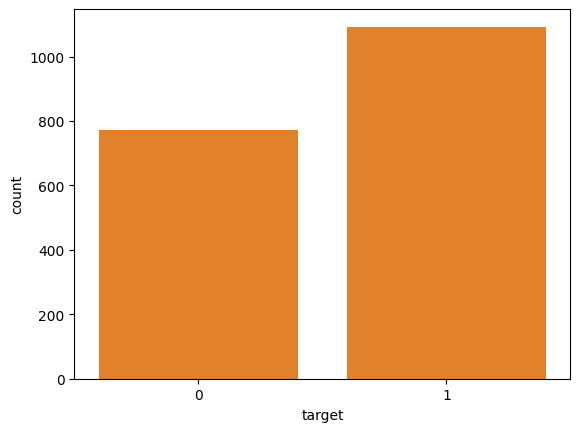

In [ ]:
# Cek imbalance target
print("Distribusi target (per-produk):")
print(product_df["target"].value_counts(normalize=True))

import seaborn as sns
sns.countplot(x=product_df["target"])

df["text_len"] = df["clean_review"].apply(lambda x: len(x.split()))
print(df["text_len"].describe())

sns.countplot(x=product_df["target"])

In [ ]:
X_train, X_test, y_train, y_test = train_test_split(
    X, y, test_size=0.2, random_state=42, stratify=y
)

SVM

In [ ]:
from sklearn.pipeline import Pipeline
from sklearn.preprocessing import StandardScaler
from sklearn.svm import SVC
from sklearn.model_selection import GridSearchCV, cross_val_score

In [ ]:
from sklearn.pipeline import Pipeline
from sklearn.preprocessing import StandardScaler
from sklearn.svm import SVC
from sklearn.model_selection import GridSearchCV

svm_pipeline = Pipeline([
    ("scaler", StandardScaler()),
    ("svm", SVC(random_state=42, probability=True))
])

svm_param_grid = {
    "svm__C": [0.1, 1, 10],
    "svm__gamma": ["scale", 0.01, 0.001]
}

svm_grid = GridSearchCV(svm_pipeline, svm_param_grid, cv=3, scoring="f1_macro", n_jobs=-1, verbose=1)
svm_grid.fit(X_train, y_train)
svm_best = svm_grid.best_estimator_
print("SVM best params:", svm_grid.best_params_)

y_pred_svm = svm_best.predict(X_test)

Fitting 3 folds for each of 9 candidates, totalling 27 fits
SVM best params: {'svm__C': 10, 'svm__gamma': 0.001}


Random Forest

In [ ]:
from sklearn.ensemble import RandomForestClassifier

In [ ]:
rf = RandomForestClassifier(n_estimators=200, random_state=42, n_jobs=-1, class_weight="balanced")

In [ ]:
rf_param_grid = {
    "n_estimators": [100, 200],
    "max_depth": [None, 20, 40]
}
rf_grid = GridSearchCV(rf, rf_param_grid, cv=3, scoring="f1_macro", n_jobs=-1, verbose=1)
rf_grid.fit(X_train, y_train)
rf_best = rf_grid.best_estimator_
print("RF best params:", rf_grid.best_params_)

y_pred_rf = rf_best.predict(X_test)

Fitting 3 folds for each of 6 candidates, totalling 18 fits
RF best params: {'max_depth': None, 'n_estimators': 200}


KNN

In [ ]:
from sklearn.neighbors import KNeighborsClassifier

In [ ]:
knn = KNeighborsClassifier()
knn_param_grid = {
    "n_neighbors": [3,5,7],
    "weights": ["uniform", "distance"],
    "metric": ["euclidean","cosine"]
}
knn_grid = GridSearchCV(knn, knn_param_grid, cv=3, scoring="f1_macro", n_jobs=-1, verbose=1)
knn_grid.fit(X_train, y_train)
knn_best = knn_grid.best_estimator_
print("KNN best params:", knn_grid.best_params_)

y_pred_knn = knn_best.predict(X_test)

Fitting 3 folds for each of 12 candidates, totalling 36 fits
KNN best params: {'metric': 'euclidean', 'n_neighbors': 7, 'weights': 'distance'}



=== Evaluasi SVM ===
Accuracy: 0.7908847184986595
              precision    recall  f1-score   support

           0       0.75      0.75      0.75       154
           1       0.82      0.82      0.82       219

    accuracy                           0.79       373
   macro avg       0.78      0.78      0.78       373
weighted avg       0.79      0.79      0.79       373



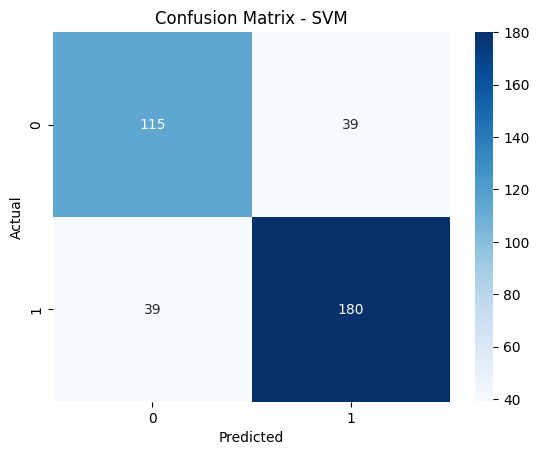


=== Evaluasi RandomForest ===
Accuracy: 0.7640750670241286
              precision    recall  f1-score   support

           0       0.79      0.58      0.67       154
           1       0.75      0.89      0.82       219

    accuracy                           0.76       373
   macro avg       0.77      0.74      0.74       373
weighted avg       0.77      0.76      0.76       373



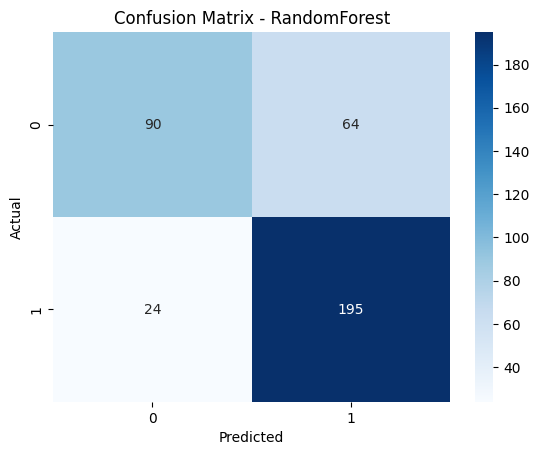


=== Evaluasi KNN ===
Accuracy: 0.710455764075067
              precision    recall  f1-score   support

           0       0.67      0.59      0.63       154
           1       0.73      0.79      0.76       219

    accuracy                           0.71       373
   macro avg       0.70      0.69      0.70       373
weighted avg       0.71      0.71      0.71       373



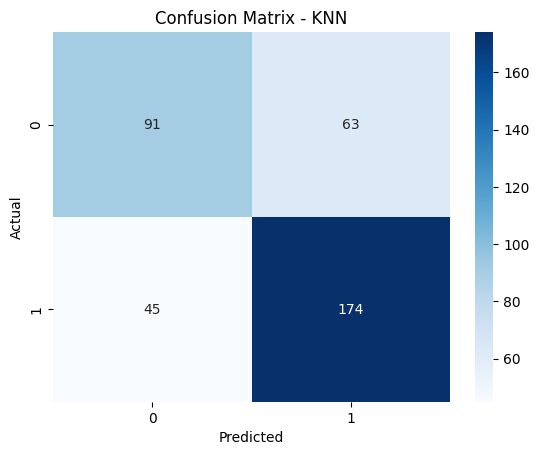

In [ ]:
def eval_model(y_true, y_pred, model_name):
    print(f"\n=== Evaluasi {model_name} ===")
    print("Accuracy:", accuracy_score(y_true, y_pred))
    print(classification_report(y_true, y_pred))
    cm = confusion_matrix(y_true, y_pred)
    sns.heatmap(cm, annot=True, fmt="d", cmap="Blues")
    plt.title(f"Confusion Matrix - {model_name}")
    plt.xlabel("Predicted"); plt.ylabel("Actual")
    plt.show()
    return {
        "model": model_name,
        "accuracy": accuracy_score(y_true, y_pred),
        "precision": precision_score(y_true, y_pred, average="weighted"),
        "recall": recall_score(y_true, y_pred, average="weighted"),
        "f1": f1_score(y_true, y_pred, average="weighted")
    }

res_svm = eval_model(y_test, y_pred_svm, "SVM")
res_rf  = eval_model(y_test, y_pred_rf,  "RandomForest")
res_knn = eval_model(y_test, y_pred_knn, "KNN")

In [ ]:
results_df = pd.DataFrame([res_svm, res_rf, res_knn])
print("Perbandingan model:")
display(results_df.sort_values(by="f1", ascending=False))

Perbandingan model:


,model,accuracy,precision,recall,f1
0,SVM,0.790885,0.790885,0.790885,0.790885
1,RandomForest,0.764075,0.767998,0.764075,0.756340
2,KNN,0.710456,0.707316,0.710456,0.707185


In [ ]:
print("Cross-val F1 macro (5-fold):")
for name, model in [("SVM", svm_best), ("RF", rf_best), ("KNN", knn_best)]:
    scores = cross_val_score(model, X, y, cv=5, scoring="f1_macro", n_jobs=-1)
    print(f"{name}: mean f1_macro = {scores.mean():.4f}  std = {scores.std():.4f}")

Cross-val F1 macro (5-fold):
SVM: mean f1_macro = 0.7899  std = 0.0152
RF: mean f1_macro = 0.7195  std = 0.0224
KNN: mean f1_macro = 0.7197  std = 0.0190


In [ ]:
from sklearn.metrics.pairwise import cosine_similarity

embedding_matrix = np.vstack(product_df["embedding"].values)

print(embedding_matrix.shape)

(1864, 384)


In [ ]:
def recommend_similar_products(product_name, top_n=5):
    if product_name not in product_df["item_reviewed"].values:
        return f"Produk '{product_name}' tidak ditemukan."

    idx = product_df[product_df["item_reviewed"] == product_name].index[0]

    sim_scores = cosine_similarity(
        [embedding_matrix[idx]],
        embedding_matrix
    )[0]

    top_idx = sim_scores.argsort()[::-1][1:top_n+1]

    results = product_df.iloc[top_idx][[
        "item_reviewed", "rating_value", "sentiment_score"
    ]].copy()

    results["similarity"] = sim_scores[top_idx]

    return results


In [ ]:
print("Total baris:", len(df))
print("Produk unik:", df["item_reviewed"].nunique())

Total baris: 7929
Produk unik: 1864


In [ ]:
test_product = product_df["item_reviewed"].iloc[10]
print("Produk test:", test_product)

recommend_similar_products(test_product)

Produk test: 1% Vitamin A Retinol Serum


,item_reviewed,rating_value,sentiment_score,similarity
1327,Retinol Fine Lines and Wrinkles Serum,3.250000,0.807252,0.703393
562,Firming & Plumping Vegan Collagen Prep Serum,3.571429,0.798724,0.701459
1305,"Resurfacing + Smoothing Body Serum with AHAs, ...",2.833333,0.782399,0.698310
94,Advanced Retinol + Ferulic Overnight Wrinkle T...,2.333333,0.881526,0.688662
51,A-Gloei™ Marula + Retinol Oil,3.000000,0.887160,0.679315


In [ ]:
for i in [10, 50, 100, 150]:
    test_product = df["item_reviewed"].iloc[i]
    print("Testing:", test_product)
    print(recommend_similar_products(test_product)[["item_reviewed"]])

Testing: Aquarius Pore Purifying BHA Cream
                                          item_reviewed
1827  Whipped Argan Oil Firming + Hydrating Face But...
1601  The Dewy Skin Cream Plumping & Hydrating Refil...
930   Mini Extreme Cream Anti-Aging, Firming, & Lift...
12    10 + 10 Moisturizer with 10% Vitamin C + 10% P...
808   Like Butter Moisturizer for Dry, Sensitive & E...
Testing: Vinoperfect Brightening Dark Spot Serum Vitamin C Alternative
                                          item_reviewed
1248  Premier Cru Anti-Aging Serum with Niacinamide ...
1102  Niacinamide 5% Face and Body Emulsion for Dark...
989   Mini O2 Growth Factor Eight Active Brightening...
493          Equilibrium Resurfacing Retinoid Treatment
680   High Performance Face Serum with Vitamin C and...
Testing: Resurfacing & Brightening AHA + BHA Serum with Vitamin C
                                          item_reviewed
1535  Superkind Bio-Barrier Serum for Skin Barrier R...
1538  Superkind Fortifying Moisturiz

In [ ]:
def hybrid_recommend(product_name, top_n=10):
    if product_name not in df["item_reviewed"].values:
        return f"Produk '{product_name}' tidak ditemukan."

    # Get the original DataFrame index label
    original_df_index_label = df[df["item_reviewed"] == product_name].index[0]
    # Convert the index label to its positional index in the current DataFrame
    positional_idx = df.index.get_loc(original_df_index_label)

    # Content based
    product_vec = embedding_matrix[positional_idx].reshape(1, -1)
    sim_scores = cosine_similarity(product_vec, embedding_matrix)[0]

    top_idx_positional = sim_scores.argsort()[::-1][1:31]
    candidates = df.iloc[top_idx_positional].copy()
    candidates["similarity"] = sim_scores[top_idx_positional]

    # Predictive model
    probas = svm_best.predict_proba(embedding_matrix[top_idx_positional])[:, 1]
    candidates["prob_highrating"] = probas

    # Hybrid Score
    candidates["hybrid_score"] = (
        0.6 * candidates["similarity"] +
        0.4 * candidates["prob_highrating"]
    )

    final = candidates.sort_values("hybrid_score", ascending=False)

    return final[[
        "item_reviewed",
        "similarity",
        "prob_highrating",
        "hybrid_score"
    ]].head(top_n)

In [ ]:
!pip install ipywidgets
from IPython.display import display
import ipywidgets as widgets

product_list = sorted(product_df["item_reviewed"].unique())

dropdown = widgets.Dropdown(
    options=product_list,
    description='Pilih Produk:',
    disabled=False,
)

display(dropdown)

   ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 1.6/1.6 MB 21.3 MB/s eta 0:00:00


Dropdown(description='Pilih Produk:', options=(' 100% Organic Cold-Pressed Moroccan Argan Oil for Skin & Hair'…

In [ ]:
def on_select(change):
    if change['type'] == 'change' and change['name'] == 'value':
        selected_product = change['new']
        display(hybrid_recommend(selected_product, top_n=5))

dropdown.observe(on_select)

In [ ]:
from IPython.display import display, clear_output
output = widgets.Output()

product_list = sorted(df["item_reviewed"].unique())

dropdown = widgets.Dropdown(
    options=product_list,
    description='Produk:',
    layout=widgets.Layout(width='500px')
)

button = widgets.Button(
    description="Lihat Rekomendasi",
    button_style='success'
)

def on_button_click(b):
    with output:
        clear_output()
        selected = dropdown.value
        display(hybrid_recommend(selected, top_n=5))

button.on_click(on_button_click)

display(dropdown, button, output)

Dropdown(description='Produk:', layout=Layout(width='500px'), options=(' 100% Organic Cold-Pressed Moroccan Ar…

Button(button_style='success', description='Lihat Rekomendasi', style=ButtonStyle())

Output()

Vektor Database

In [ ]:
!pip install faiss-cpu

   ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 23.7/23.7 MB 31.4 MB/s eta 0:00:00


In [ ]:
import faiss
import numpy as np
import pandas as pd
import joblib
from sklearn.preprocessing import MinMaxScaler
from sklearn.metrics.pairwise import cosine_similarity

In [ ]:
faiss_embed = np.vstack(product_df["embedding"].values).astype("float32")
faiss.normalize_L2(faiss_embed)
dimension = faiss_embed.shape[1]
print(f"FAISS shape: {faiss_embed.shape}, dim: {dimension}")

FAISS shape: (1864, 384), dim: 384


In [ ]:
index = faiss.IndexFlatIP(dimension)
index.add(faiss_embed)

print("Total vektor produk masuk ke FAISS:", index.ntotal)

Total vektor produk masuk ke FAISS: 1864


In [ ]:
def faiss_search(product_name, top_n=10):
    if product_name not in product_df["item_reviewed"].values:
        return f"Produk '{product_name}' tidak ditemukan."

    idx = product_df[product_df["item_reviewed"] == product_name].index[0]
    query_vector = faiss_embed[idx].reshape(1, -1)

    D, I = index.search(query_vector, top_n + 1)

    hasil = product_df.iloc[I[0][1:]].copy()
    hasil["faiss_similarity"] = D[0][1:]

    return hasil[["item_reviewed", "rating_value", "sentiment_score", "faiss_similarity"]]

In [ ]:
test_item = df["item_reviewed"].iloc[20]
print("Produk Uji", test_item)
faiss_search(test_item, top_n=5)

Produk Uji Moisturizing Body Wash Oil Rich Cleanser in Midnite Amber


,item_reviewed,rating_value,sentiment_score,faiss_similarity
1579,The Body Wash Eucalyptus - Nourishing Treatmen...,4.285714,0.868224,0.792092
1580,The Body Wash Eucalyptus - Nourishing Treatmen...,4.555556,0.833527,0.790287
1037,Mini The Body Wash Eucalyptus - Nourishing Tre...,4.500000,0.937020,0.770172
1584,The Body Wash Olibanum – Radiance Treatment Cl...,4.428571,0.948681,0.768898
554,Find Comfort Gentle Exfoliating Konjac Jelly B...,4.400000,0.774473,0.744844


In [ ]:
def hybrid_faiss(product_name, top_n=10):
    if product_name not in product_df["item_reviewed"].values:
        return f"Produk '{product_name}' tidak ditemukan."

    idx = product_df[product_df["item_reviewed"] == product_name].index[0]
    query_vector = faiss_embed[idx].reshape(1, -1)

    D, I = index.search(query_vector, 50)

    candidate_idx = I[0][1:]  # skip diri sendiri
    faiss_sim = D[0][1:]

    candidates = product_df.iloc[candidate_idx].copy()
    candidates["faiss_sim"] = faiss_sim  # nilai similarity positif (0-1)

    # SVM prediction berdasarkan embedding produk
    probas = svm_best.predict_proba(np.vstack(product_df.iloc[candidate_idx]["embedding"]))[:, 1]
    candidates["prob_svm"] = probas

    # Hybrid baru (sudah relevan)
    candidates["hybrid_score"] = (
        0.6 * candidates["faiss_sim"] +
        0.4 * candidates["prob_svm"]
    )

    final = candidates.sort_values("hybrid_score", ascending=False)

    return final[[
        "item_reviewed", "faiss_sim", "prob_svm", "hybrid_score", "sentiment_score"
    ]].head(top_n)


In [ ]:
produk_test = df["item_reviewed"].iloc[50]
print("Produk:", produk_test)
hybrid_faiss(produk_test, top_n=5)

Produk: Vinoperfect Brightening Dark Spot Serum Vitamin C Alternative


,item_reviewed,faiss_sim,prob_svm,hybrid_score,sentiment_score
1467,Squalane + 10% Lactic Acid Resurfacing Serum,0.847069,0.980954,0.900623,0.879079
1239,Power Move Plumping + Hydrating Serum with Hya...,0.849391,0.958084,0.892868,0.931370
1678,The Retinol Serum,0.839126,0.960025,0.887486,0.886210
630,Glow Serum for Oil Control with Niacinamide,0.826691,0.954551,0.877835,0.974337
1017,Mini Sea Vitamin C Serum for Brightening Dark ...,0.850479,0.916328,0.876819,0.760026


In [ ]:
if "embedding" in df.columns:
    embedding_matrix = np.vstack(df["embedding"].values).astype("float32")
else:
    raise ValueError("Kolom 'embedding' tidak ditemukan di df. Jalankan sel pembuatan embedding dulu.")

similarity_matrix = cosine_similarity(embedding_matrix)
if "item_reviewed" in df.columns:
    item_index = df["item_reviewed"].astype(str).values
elif "itemName" in df.columns:
    item_index = df["itemName"].astype(str).values
else:
    item_index = df.index.astype(str).values
    print("Kolom nama produk tidak ditemukan, menggunakan index sebagai label.")

df_sim = pd.DataFrame(similarity_matrix, index=item_index, columns=item_index)

print("Matriks Similaritas Produk (contoh 10x10, dibulatkan 3 desimal):")
display(df_sim.iloc[:10, :10].round(3))

def top_n_similar(product_name_or_index, top_n=10):
    if str(product_name_or_index) in df_sim.index:
        scores = df_sim.loc[str(product_name_or_index)]
    else:
        pos = int(product_name_or_index)
        scores = pd.Series(similarity_matrix[pos], index=df_sim.index)

    top = scores.sort_values(ascending=False).iloc[1:top_n+1]  # skip diri sendiri
    return top.reset_index().rename(columns={"index":"item_reviewed", 0:"similarity"})

example_idx = 10
print(f"\nTop 5 produk mirip dengan indeks {example_idx} / nama '{item_index[example_idx]}':")
display(top_n_similar(example_idx, top_n=5))

Matriks Similaritas Produk (contoh 10x10, dibulatkan 3 desimal):


,Hydrating Sunscreen Milk with Colloidal Oatmeal BROAD SPECTRUM 45,No.04 Bois de Balincourt Perfume Oil Rollerball,Glowscreen Soft-Radiance Drops Mineral SPF 40,Superfood Air-Whip Lightweight Face Moisturizer with Hyaluronic Acid,Nomad’s Cream Purifying & Exfoliating AHA Cleanser,Plant Stem Cell Retinol Alternative Firming Moisturizer,ATOBARRIER365 Moisturizing Body Lotion with Ceramides for Dry & Sensitive Skin,Mini Mineral Mattescreen Sunscreen SPF 40,Sea the Glow® Mara's Discovery Skincare Gift Set,Pure Clean Daily Facial Cleanser
Hydrating Sunscreen Milk with Colloidal Oatmeal BROAD SPECTRUM 45,1.000,0.226,0.400,0.313,0.338,0.311,0.375,0.352,0.298,0.289
No.04 Bois de Balincourt Perfume Oil Rollerball,0.226,1.000,0.197,0.375,0.250,0.184,0.144,0.063,0.226,0.136
Glowscreen Soft-Radiance Drops Mineral SPF 40,0.400,0.197,1.000,0.431,0.459,0.337,0.514,0.397,0.445,0.326
Superfood Air-Whip Lightweight Face Moisturizer with Hyaluronic Acid,0.313,0.375,0.431,1.000,0.377,0.339,0.647,0.420,0.594,0.325
Nomad’s Cream Purifying & Exfoliating AHA Cleanser,0.338,0.250,0.459,0.377,1.000,0.360,0.445,0.250,0.386,0.330
Plant Stem Cell Retinol Alternative Firming Moisturizer,0.311,0.184,0.337,0.339,0.360,1.000,0.365,0.248,0.362,0.382
ATOBARRIER365 Moisturizing Body Lotion with Ceramides for Dry & Sensitive Skin,0.375,0.144,0.514,0.647,0.445,0.365,1.000,0.426,0.538,0.312
Mini Mineral Mattescreen Sunscreen SPF 40,0.352,0.063,0.397,0.420,0.250,0.248,0.426,1.000,0.391,0.299
Sea the Glow® Mara's Discovery Skincare Gift Set,0.298,0.226,0.445,0.594,0.386,0.362,0.538,0.391,1.000,0.303
Pure Clean Daily Facial Cleanser,0.289,0.136,0.326,0.325,0.330,0.382,0.312,0.299,0.303,1.000



Top 5 produk mirip dengan indeks 10 / nama 'Aquarius Pore Purifying BHA Cream':


,item_reviewed,similarity
0,Aquarius Pore Purifying BHA Cream,1.000000
1,Whipped Argan Oil Firming + Hydrating Face But...,0.707798
2,Whipped Argan Oil Firming + Hydrating Face But...,0.707798
3,"Like Butter Moisturizer for Dry, Sensitive & E...",0.660102
4,Indigo Overnight Repair Redness Reducing Barri...,0.645041


In [ ]:
embedding_matrix = np.vstack(df["embedding"].values).astype("float32")
similarity_matrix = cosine_similarity(embedding_matrix)
item_labels = df["item_reviewed"].astype(str).values

df_sim = pd.DataFrame(
    similarity_matrix,
    index=item_labels,
    columns=item_labels
)

print("Matriks Similaritas Produk (dibulatkan 3 desimal):")
print(df_sim.round(3))

Matriks Similaritas Produk (dibulatkan 3 desimal):
                                                    Hydrating Sunscreen Milk with Colloidal Oatmeal BROAD SPECTRUM 45  \
Hydrating Sunscreen Milk with Colloidal Oatmeal...                                              1.000                   
No.04 Bois de Balincourt Perfume Oil Rollerball                                                 0.226                   
Glowscreen Soft-Radiance Drops Mineral SPF 40                                                   0.400                   
Superfood Air-Whip Lightweight Face Moisturizer...                                              0.313                   
Nomad’s Cream Purifying & Exfoliating AHA Cleanser                                              0.338                   
...                                                                                               ...                   
Clarifying Pore AHA + BHA Mask with Salicylic A...                                              0.329 

Chatbot

In [ ]:
!pip install -q -U google-generativeai

In [ ]:
import google.generativeai as genai
import getpass
import os

print("Masukkan API Key Anda pada kotak...")
try:
    api_key = getpass.getpass()
    genai.configure(api_key=api_key)
    print("API Key berhasil dimasukkan!")
except Exception as e:
    print(f"Gagal memuat API Key: {e}")

model = genai.GenerativeModel('gemini-2.5-flash')

Masukkan API Key Anda pada kotak...
··········
✅ API Key berhasil dimasukkan!


In [ ]:
def jelaskan_rekomendasi(nama_produk_input):
    print(f"🤖 Sedang mencari alasan rekomendasi untuk '{nama_produk_input}'...\n")

    # Ambil rekomendasi teratas dari hybrid
    rekom = hybrid_faiss(nama_produk_input, top_n=1)

    if isinstance(rekom, str):
        print(f"❌ {rekom}")
        return

    data = rekom.iloc[0]

    rec_item = data['item_reviewed']
    faiss_sim = data['faiss_sim']
    prob_rating = data['prob_svm']
    sent_score = data['sentiment_score']

    # Konversi sentimen menjadi deskripsi
    if sent_score >= 0.65:
        sentimen_desc = "mayoritas penggunanya merasa puas"
    elif sent_score >= 0.45:
        sentimen_desc = "respon penggunanya cukup beragam namun cenderung positif"
    else:
        sentimen_desc = "ada beberapa kritik dari pengguna, namun masih relevan sebagai pilihan alternatif"

    # Buat prompt AI TANPA angka
    prompt = f"""
Anda adalah asisten rekomendasi produk kecantikan.
Jelaskan secara singkat dan objektif mengapa produk **{rec_item}** cocok direkomendasikan
kepada pengguna yang sedang melihat **{nama_produk_input}**.

Informasi yang dapat digunakan dalam penjelasan:
- Produk ini memiliki kemiripan dari segi fungsi, manfaat, atau karakteristik formulanya.
- Berdasarkan ulasan pengguna, {sentimen_desc}.
- Prediksi model menunjukkan produk ini berpotensi memberikan pengalaman yang memuaskan bagi pengguna.
- Jelaskan dalam nada ramah dan informatif, tanpa menyebut angka, skor, atau nilai teknis.

Berikan 3–6 kalimat yang jelas, tidak berlebihan, tidak mengklaim hasil medis, dan tidak menggunakan angka.
"""

    try:
        response = model.generate_content(prompt)

        print("="*60)
        print(f"✨ REKOMENDASI TERBAIK: {rec_item}")
        print("="*60)
        print(response.text)
        print("-" * 60)
        print("🔍 Penjelasan ini berbasis analisis similarity, prediksi rating, dan sentimen pengguna.")
    except Exception as e:
        print(f"Maaf, terjadi kesalahan koneksi ke Gemini: {e}")


In [ ]:
jelaskan_rekomendasi("Glowscreen Soft-Radiance Drops Mineral SPF 40")

🤖 Sedang mencari alasan rekomendasi untuk 'Glowscreen Soft-Radiance Drops Mineral SPF 40'...

✨ REKOMENDASI TERBAIK: Skin Glow SPF 30 Primer with Niacinamide
Jika Anda menyukai Glowscreen Soft-Radiance Drops, kami punya rekomendasi menarik untuk Anda. Skin Glow SPF 30 Primer with Niacinamide ini menawarkan fungsi serupa, memberikan kilau cantik pada kulit sekaligus perlindungan dari sinar matahari. Produk ini juga berfungsi sebagai primer yang menyiapkan kulit Anda dengan sempurna untuk tampilan riasan yang halus. Banyak pengguna merasa sangat puas dengan hasilnya, dan kami memprediksi produk ini berpotensi memberikan pengalaman yang memuaskan bagi Anda.
------------------------------------------------------------
🔍 Penjelasan ini berbasis analisis similarity, prediksi rating, dan sentimen pengguna.


In [ ]:
import joblib
import faiss
import os

os.makedirs('model', exist_ok=True)

# product_df
product_df.to_pickle("model/products.pkl")

# SVM
joblib.dump(svm_best, "model/svm_model.pkl")

# FAISS index
faiss.write_index(index, "model/faiss_index.bin")